In [1]:
# Import tensorflow and keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model

# Import processing and displaying modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import sys

In [2]:
# Set the main path as the DLProject folder
main_path = os.path.abspath("../")
sys.path.append(main_path)

# Import mmwchanmod module from the main path.
# mmwchanmod module is cloned from nyu-wireless 
# github sites for processing the pickle file.
# https://github.com/nyu-wireless/mmwchanmod
import mmwchanmod

In [3]:
# Load the pre-processed ray tracing data
# The train_data is used to train the GAN
# and the test_data is used to generate channel
# samples and to evaluate the GAN performance.
fn = 'factory_warehouse.p'
with open(os.path.join(main_path,fn), 'rb') as fp:
    config,train_data,test_data = pickle.load(fp)
    
# Display the path information contained in the pickle file.
# The eight parameters are
# dvec: The dista, end =" "nce vector between the transmitter and the receiver
# link_state: The state of link: LOS, NLOS, or Outage
# los_pl: The path loss of the LOS path if it exists
# los_ang: The four angles (AOA, ZOA, AOD, ZOD) of the LOS path if it exists
# los_dly: The time delay of the LOS path if it exists
# nlos_pl: The path loss of the NLOS paths
# nlos_ang: The four angles of the NLOS paths
# nlos_dly: The time delay of the NLOS paths
# tx_pos
print(f"There are {train_data['dvec'].shape[0]} links in the train dataset.")
print("Ten path parameters:")
for key in train_data.keys():
    print(key, end =", ")

There are 1759 links in the train dataset.
Ten path parameters:
dvec, link_state, los_pl, los_ang, los_dly, nlos_pl, nlos_ang, nlos_dly, tx_pos, rx_pos, 

In [4]:
# Separate the train datasets into three subsets:
# LOS, NLOS, Outage
# LOS: A boresight path exists between the TX and RX
# NLOS: The boresight path is blocked
# Outage: No paths between the TX and RX
num_link = train_data['dvec'].shape[0]
train_data['dist'] = np.zeros(num_link)
train_data['pl_omni'] = np.zeros(num_link)

# Initialize the indices of three subsets
los_index = []
nlos_index = []
outage_index = []
for link in range(num_link):
  if train_data['link_state'][link] == 1:
    los_index.append(link)
  elif train_data['link_state'][link] == 2:
    nlos_index.append(link)
  elif train_data['link_state'][link] == 0:
    outage_index.append(link)
  else:
    print(f'Unexpected link state at {link}')
    
  # Only use the distance and path loss values here for path loss plots
  dvec = train_data['dvec'][link]
  train_data['dist'][link] = np.sqrt(np.dot(dvec,dvec))
  los_pl = train_data['los_pl'][link]
  nlos_pl = train_data['nlos_pl'][link]
  nlos_pr_lin = np.sum(10**((0-nlos_pl)/10))
  pr_lin = 10**((0-los_pl)/10) + nlos_pr_lin
  train_data['pl_omni'][link] = 0-10*np.log10(pr_lin)

In [5]:
# Import scipy module for scientific constants 
from scipy.constants import c, pi
# Carrier frequency:28 GHz
fc = 28e9
# Wavelength
lamb = c/fc
# Anchor distance: 1 m
d0 = 1
# Free space path loss at 1 m
fspl0 = 20*np.log10(4*pi*d0*fc/c)
# The maximum number of paths per link
num_paths = 20

In [6]:
def compute_ple(dist_vals, pl_vals, fc, d0):
  """
  Compute the path loss exponent (PLE) and shadow fading (SF)  

  Parameters
  ----------
  dist_vals : (n,) array
      TX-RX separation distance
  pl_vals : (n,) array
      Path loss in dB scale
  fc : scalar
      Carrier frequency
  d0 : scalar
      Anchor distance

  Returns
  -------
  ple:  scalar
      PLE
  sf_std:  scalar
      Standard deviation of SF
  """
  lamb = c/fc
  fspl0 = 20*np.log10(4*pi*d0*fc/c)
  dist = 10*np.log10(dist_vals).reshape((-1,1))
  pl = pl_vals.reshape((-1,1)) - fspl0

  # Compute the optimal PLE
  ple,res_sum,_,_ = np.linalg.lstsq(dist,pl,rcond=None)
  ple = ple.item()
  # Compute the corresponding SF
  sf_std = np.sqrt(res_sum/dist.shape[0]).item()
    
  return ple, sf_std

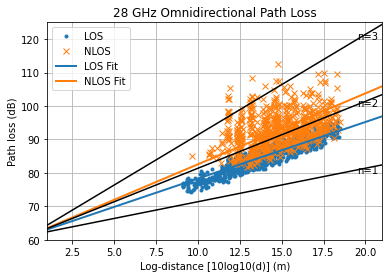

LOS locations - PLE:1.69, SF:1.66
NLOS locations - PLE:2.12, SF:5.19


In [7]:
# Compute the PLE and SF for LOS and NLOS datasets
ple_los, sf_los_std = compute_ple(train_data['dist'][los_index],
                                  train_data['pl_omni'][los_index], fc, d0)

ple_nlos, sf_nlos_std = compute_ple(train_data['dist'][nlos_index],
                                  train_data['pl_omni'][nlos_index], fc, d0)

# Scatter plot for the LOS and NLOS locations
plt.plot(10*np.log10(train_data['dist'][los_index]),train_data['pl_omni'][los_index],'.',c='C0')
plt.plot(10*np.log10(train_data['dist'][nlos_index]),train_data['pl_omni'][nlos_index],'x',c='C1')
plt.xlim([1,21])
plt.ylim([60,125])

# Plot the fit line for the LOS and NLOS locations
plt.plot(np.linspace(0,21,num=100),fspl0+ple_los*np.linspace(0,21,num=100),
         c='C0',lw=2)
plt.plot(np.linspace(0,21,num=100),fspl0+ple_nlos*np.linspace(0,21,num=100),
         c='C1',lw=2)
plt.legend(['LOS','NLOS','LOS Fit','NLOS Fit'])

# Plot the reference lines
plt.plot(np.linspace(0,21,num=100),fspl0+2*np.linspace(0,21,num=100),'k')
plt.plot(np.linspace(0,21,num=100),fspl0+1*np.linspace(0,21,num=100),'k')
plt.plot(np.linspace(0,21,num=100),fspl0+3*np.linspace(0,21,num=100),'k')
plt.annotate('n=1',(19.5,80))
plt.annotate('n=2',(19.5,100))
plt.annotate('n=3',(19.5,120))
plt.title('28 GHz Omnidirectional Path Loss')
plt.xlabel('Log-distance [10log10(d)] (m)')
plt.ylabel('Path loss (dB)')
plt.grid(True)
plt.show()

print(f'LOS locations - PLE:{ple_los:.2f}, SF:{sf_los_std:.2f}')
print(f'NLOS locations - PLE:{ple_nlos:.2f}, SF:{sf_nlos_std:.2f}')

In [8]:
# Import the MinMaxScaler to properly scale input data
from sklearn.preprocessing import MinMaxScaler
# Define own function for scaling
def data_scaler(data_in, range):
  """
  Scale the input data and record the scaler.  

  Parameters
  ----------
  data_in : (n,) array
      The data to be scaled
  range : (1,2) array
      The minimum and maximum value

  Returns
  -------
  data_out : (n,) array
      The scaled data
  scaler : object
      The scaling setting
  """

  scaler = MinMaxScaler(feature_range=range)
  data_out = scaler.fit_transform(data_in)
  return data_out, scaler

In [9]:
def compute_los_dir(dvec):
  """
  Compute the LOS direction  

  Parameters
  ----------
  dvec : (n,3) array
      The distances in three axis

  Returns
  -------
  aoa:  (n,) array
      Azimuth angle of arrival
  zoa:  (n,) array
      Elevation angle of arrival
  aod:  (n,) array
      Azimuth angle of departure
  zod:  (n,) array
      Elevation angle of departure
  """

  x = dvec[:,0]
  y = dvec[:,1]
  z = dvec[:,2]
  aod = np.arctan(y/x)*180/pi
  zod = np.arctan(np.linalg.norm(dvec[:,0:2])/z)*180/pi
  zoa = 180 - zod
  aoa = np.zeros_like(aod)
  for i in range(dvec.shape[0]):
    if aod[i] >= 0:
      aoa[i] = aod[i] - 180
    else:
      aoa[i] = aod[i] + 180

  return (aoa, zoa, aod, zod)

In [10]:
# Define some utility functions for coordinate transform
def cart_to_sph(d):
    """
    Cartesian to spherical coordinates.  

    Parameters
    ----------
    d : (n,3) array
        vector of positions

    Returns
    -------
    r:  (n,) array
        radius of each point
    phi, theta:  (n,) arrays
        azimuth and inclination angles in degrees
    """
    
    # Compute radius
    r = np.sqrt(np.sum(d**2,axis=1))
    r = np.maximum(r, 1e-8)
    
    # Compute angle of departure
    phi = np.arctan2(d[:,1], d[:,0])*180/np.pi
    theta = np.arccos(d[:,2]/r)*180/np.pi        
    
    return r, phi, theta

def sph_to_cart(r, phi, theta):
    """
    Spherical coordinates to cartesian coordinates

    Parameters
    ----------
    r:  (n,) array
        radius of each point
    phi, theta:  (n,) arrays
        azimuth and inclination angles in degrees

    Returns
    -------
    d : (n,3) array
        vector of positions

    """
    
    # Convert to radians
    phi = phi*np.pi/180
    theta = theta*np.pi/180
    
    # Convert to cartesian
    d0 = r*np.cos(phi)*np.sin(theta)
    d1 = r*np.sin(phi)*np.sin(theta)
    d2 = r*np.cos(theta)
    d = np.stack((d0,d1,d2), axis=-1)
         
    return d


def spherical_add_sub(phi0,theta0,phi1,theta1,sub=True):
    """
    Angular addition and subtraction in spherical coordinates
    
    For addition, we start with a vector at (phi0,theta0), then rotate by
    theta1 in the (x1,x3) plane and then by phi1 in the (x1,x2) plane.
    For subtraction, we start with a vector at (phi0,theta0), then rotate by
    -phi1 in the (x1,x2) plane and then by -theta1 in the (x1,x3) plane.
        

    Parameters
    ----------
    phi0, theta0 : arrays of same size
        (azimuth,inclination) angle of the initial vector in degrees 
    phi1, theta1 : arrays of same size
        (azimuth,inclination) angle of the rotation
    sub:  boolean
        if true, the angles are subtracted.  otherwise, they are added

    Returns
    -------
    phi2, theta2 : arrays of same size as input
        (azimuth,inclination) angle of the rotated vector

    """
       
        
    # Convert to radians 
    theta0 = np.pi/180*theta0
    theta1 = np.pi/180*theta1
    phi0 = np.pi/180*phi0
    phi1 = np.pi/180*phi1
    
    
    if sub:
        # Find unit vector in direction of (theta0,phi0)
        x1 = np.sin(theta0)*np.cos(phi0)
        x2 = np.sin(theta0)*np.sin(phi0)
        x3 = np.cos(theta0)
            
        # Rotate by -phi1. 
        y1 =  x1*np.cos(phi1) + x2*np.sin(phi1)
        y2 = -x1*np.sin(phi1) + x2*np.cos(phi1)
        y3 = x3
        
        # Rotate by -theta1
        z1 =  y1*np.cos(theta1) - y3*np.sin(theta1)
        z3 =  y1*np.sin(theta1) + y3*np.cos(theta1)
        z2 = y2
        z1 = np.minimum(1, np.maximum(-1, z1))
                
        # Compute the angle of the transformed vector
        # we use the (z3,z2,z1) coordinate system
        phi2 = np.arctan2(z2, z3)*180/np.pi
        theta2 = np.arcsin(z1)*180/np.pi
    else:
        
        # Find unit vector in direction of (theta0,phi0)
        x3 = np.cos(theta0)*np.cos(phi0)
        x2 = np.cos(theta0)*np.sin(phi0)
        x1 = np.sin(theta0)
        
     
        # Rotate by theta1
        y1 =  x1*np.cos(theta1) + x3*np.sin(theta1)
        y3 = -x1*np.sin(theta1) + x3*np.cos(theta1)
        y2 = x2
        
        # Rotate by phi1. 
        z1 =  y1*np.cos(phi1) - y2*np.sin(phi1)
        z2 =  y1*np.sin(phi1) + y2*np.cos(phi1)
        z3 = y3
        z3 = np.minimum(1, np.maximum(-1, z3))
        
        # Compute angles
        phi2 = np.arctan2(z2, z1)*180/np.pi
        theta2 = np.arccos(z3)*180/np.pi
                                
    
    return phi2, theta2

In [11]:
def dataset_scaler(dvec, nlos_info, num_paths):
  """
  Scale the dataset into proper range

  Parameters
  ----------
  dvec : (n,3) array
      The distances in three axis
  nlos_info: (n,120) array
      The six-element tuple information for 20 paths
  num_paths: scalar
      The number of paths per link
      
  Returns
  -------
  nlos_info_scaled:  (n,120) array
      Scaled path information
  scalar_list: list
      A list of scaler used for different link parameters
  """
  scaler_list = []

  aoa, zoa, aod, zod = compute_los_dir(dvec)

  nlos_info_scaled = np.zeros_like(nlos_info)
  # Data preprocessing
  # Power
  pl_arr = nlos_info[:,np.array(range(num_paths))*6]
  pl_scaled, pl_scaler = data_scaler(pl_arr.reshape((-1,1)),(0,1))
  nlos_info_scaled[:,np.array(range(num_paths))*6] = pl_scaled.reshape(-1,num_paths)
  scaler_list.append(pl_scaler)
  # Delay
  dly_arr = nlos_info[:,np.array(range(num_paths))*6+1]
  dly_scaled, dly_scaler = data_scaler(dly_arr.reshape((-1,1)),(0,1))
  nlos_info_scaled[:,np.array(range(num_paths))*6+1] = dly_scaled.reshape(-1,num_paths)
  scaler_list.append(dly_scaler)

  # Arrival angles
  aoa_arr = nlos_info[:,np.array(range(num_paths))*6+2]
  zoa_arr = nlos_info[:,np.array(range(num_paths))*6+3]

  # LOS arrival angles
  aoa = np.transpose(np.tile(aoa,[num_paths,1]))
  zoa = np.transpose(np.tile(zoa,[num_paths,1]))

  # with respect to LOS direction
  arrival_angles_rot = spherical_add_sub(aoa_arr,zoa_arr,aoa,zoa)
 
  aoa_arr_wl = arrival_angles_rot[0] % 360
  zoa_arr_wl = arrival_angles_rot[1] % 360

  # Departure angles
  aod_arr = nlos_info[:,np.array(range(num_paths))*6+4]
  zod_arr = nlos_info[:,np.array(range(num_paths))*6+5]

  # LOS departure angles
  aod = np.transpose(np.tile(aod,[num_paths,1]))
  zod = np.transpose(np.tile(zod,[num_paths,1]))

  # with respect to LOS direction
  depart_angles_rot = spherical_add_sub(aod_arr,zod_arr,aod,zod)
  
  aod_arr_wl = depart_angles_rot[0] % 360
  zod_arr_wl = depart_angles_rot[1] % 360
  
  # Group all link parameters into the nlos_info_scaled array
  ang_arr_wl = np.concatenate((aoa_arr_wl,zoa_arr_wl,aod_arr_wl,zod_arr_wl),axis=1)
  ang_scaled, ang_scaler = data_scaler(ang_arr_wl.reshape((-1,1)),(0,1))
  ang_scaled = ang_scaled.reshape((-1,num_paths*4))
  ang_index = np.arange(4).reshape((1,-1)) + np.arange(20).reshape((-1,1))*6 + 2
  ang_index = ang_index.reshape((1,-1))[0]
  nlos_info_scaled[:,ang_index] = ang_scaled
  scaler_list.append(ang_scaler)

  return nlos_info_scaled, scaler_list

In [12]:
def data_transform(dataset):
  """
  Main function to transform the raw train data into the proper shape for later training

  Parameters
  ----------
  dataset : from pickle file
      Train or test dataset
      
  Returns
  -------
  data_loader:  (n,124) array
      Scaled dataset
  scalar_list: list
      A list of scaler used for different link parameters
  """
  num_links = dataset['link_state'].shape[0]
  num_paths = 20
  nlos_info = np.zeros((num_links, 6*num_paths))
  data_loader = np.zeros((num_links, 6*num_paths+4))
  for ipath in range(num_paths):
    nlos_info[:,ipath*6] = dataset['nlos_pl'][:,ipath]
    nlos_info[:,ipath*6+1] = dataset['nlos_dly'][:,ipath]
    nlos_info[:,ipath*6+2:ipath*6+6] = dataset['nlos_ang'][:,ipath,:]
  
  nlos_info, scaler_list = dataset_scaler(dataset['dvec'], nlos_info, num_paths)

  for ilk in range(num_links):
    dvec_this = dataset['dvec'][ilk,:]
    d_3D_this = np.linalg.norm(dvec_this)
    lkstate_this = dataset['link_state'][ilk]
    u = np.array([d_3D_this, 10*np.log10(d_3D_this), dvec_this[2], lkstate_this])
    x = nlos_info[ilk,:]
    data_loader[ilk,:] = np.concatenate((u,x))
  return data_loader, scaler_list

In [13]:
# Transform the train and test datasets
# Order: d_3D, 10log10(d_3D), d_z, los/nlos, 6 parameters by 20 paths
train_samples,scaler_train = data_transform(train_data)
test_samples,scaler_test = data_transform(test_data)

In [14]:
# Hyperparameters for the link prediction network
input_size = 8 # tx_pos, rx_pos, d_3D and d_z 
label_size = 3
BATCH_SIZE = 128

In [15]:
# Extract the data and label used for the link prediction network
num_samples_train = train_samples.shape[0]

lsp_train = np.concatenate((train_samples[:,[0,2]], train_data['tx_pos'], train_data['rx_pos']), axis=1)
lsp_test = np.concatenate((test_samples[:,[0,2]], test_data['tx_pos'], test_data['rx_pos']), axis=1)
all_samples = np.concatenate((lsp_train, lsp_test))

# all_samples = np.concatenate((train_samples[:,[0,2]], test_samples[:,[0,2]]))
# link_train = train_samples[:,[0,2]]
# link_test = test_samples[:,[0,2]]

link_scaler = MinMaxScaler(feature_range=(0,1))
all_samples_scaled = link_scaler.fit_transform(all_samples)

link_train = all_samples_scaled[0:num_samples_train, :]
link_test = all_samples_scaled[num_samples_train:, :]
label_train = train_samples[:,3]
label_test = test_samples[:,3]
num_labels = len(np.unique(label_train))

# One-hot encoded labels
label_train = to_categorical(label_train)
label_test = to_categorical(label_test)

In [16]:
# Train and test the link state net
def make_state_model():
  """
  Creat the link prediction network

  Returns
  -------
  model : Link predictor
  """
  model = Sequential()
  model.add(Dense(20, input_dim=input_size))
  model.add(Activation('sigmoid'))
  model.add(Dense(40))
  model.add(Activation('sigmoid'))
  model.add(Dense(label_size))
  model.add(Activation('softmax'))
  # model.summary()
  
  return model

In [17]:
# Instantiate the link state prediction net
link_state_model = make_state_model()
# Compile it with cross entropy loss and RMSprop optimizer
link_state_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])
# Train the network
link_state_model.fit(link_train, label_train, epochs=1000, batch_size=BATCH_SIZE,
                     verbose=0)

# Calculate the train accuracy
_, acc_train = link_state_model.evaluate(link_train,
                        label_train,
                        batch_size=BATCH_SIZE,
                        verbose=0)

# Calculate the test accuracy
_, acc_test = link_state_model.evaluate(link_test,
                        label_test,
                        batch_size=BATCH_SIZE,
                        verbose=0)
print(f"Train accuracy: {100.0 * acc_train:.1f} \n Test accuracy: {100.0 * acc_test:.1f}")

Train accuracy: 88.2 
 Test accuracy: 83.4


In [18]:
def link_state_predict(model, data):
  """
  Predict the link state for the input data
  
  Parameters
  ----------
  model : Model
      Trained link prediction network
  data : (n,2) array
      The distance information as input data
      
  Returns
  -------
  link_state_arr : (n,) array
      Array of predicted state per link
  """
  num_links = data.shape[0]
  link_state_arr = np.zeros(num_links)
  for i in range(data.shape[0]):
    p_pred = model.predict(data[i,:].reshape((1,-1)))
    link_state_arr[i] = np.random.choice(3,p=p_pred[0])

  return link_state_arr

In [19]:
# Creat tensorflow batched datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_samples)
test_dataset = tf.data.Dataset.from_tensor_slices(test_samples)

BUFFERSIZE = train_samples.shape[0]
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFERSIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BUFFERSIZE)

In [20]:
def build_generator(inputs, 
                    path_size,
                    labels, 
                    activation='sigmoid'):
  """
  Build the generator model of ACGAN

  Parameters
  ----------
  inputs : (None,20)
      Noise vectors
  path_size : (None, 120)
      Output path information
  labels : (None, 2)
      One-hot vector of LOS/NLOS
  activation : string
      activation function at the output layer
  
      
  Returns
  -------
  generator: Model
      Generator model of ACGAN
  """
  
  # Pre-defined two hidden layers with 32 and 64 nodes
  hidden_layers = [32, 64]

  inputs_label = [inputs, labels]
  x = concatenate(inputs_label, axis=1)
  
  # For each set of hidden layer, it contains:
  # one dense layer, one batch norm layer, and one activation layer
  for layer in hidden_layers:
    x = Dense(layer)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)

  # Output layer with specified activation function
  x = Dense(path_size)(x)
  if activation is not None:
    x = Activation(activation)(x)
  generator = Model(inputs_label, x, name='generator')

  return generator

In [21]:
def build_discriminator(inputs, 
                        num_labels, 
                        activation='sigmoid'):
  """
  Build the discriminator model of ACGAN

  Parameters
  ----------
  inputs : (None,120)
      Path vectors
  num_labels: scalar
      The number of labels (2)
  activation : string
      activation function at the output layer
  
      
  Returns
  -------
  generator: Model
      Generator model of ACGAN
  """
  x = inputs
  hidden_layers = [64, 32]
  for layer in hidden_layers:
    x = Dense(layer)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
  
  outputs = Dense(1)(x)

  if activation is not None:
    outputs = Activation(activation)(outputs)

  if num_labels:
    y = Dense(hidden_layers[1])(x)
    y = Dense(num_labels)(y)
    y = Activation('softmax',name='label')(y)
    outputs = [outputs, y]

  return Model(inputs, outputs, name='discriminator')

In [22]:
def train(models, data, params):
  """
  Train the ACGAN (discriminator and generator iteratively)
  The train procedure is written and modified based on an open-source 
  implementation:
  https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/
  blob/master/chapter5-improved-gan/acgan-mnist-5.3.1.py
  
  Parameters
  ----------
  models : Tuple of models
      generator model, discriminator model, and adversarial model
  data : Tuple of arrays
      train data and labels
  params : Tuple of hyperparameters
      batch_size,
      latent_size,
      train_steps,
      num_labels,
      num_samples_generate,
      model_name
      
  Returns
  -------
      trained generator and discriminator models
  """
  generator, discriminator, adversarial = models
  x_train, y_train = data
  batch_size, latent_size, train_steps, num_labels, num_samples_generate, \
        model_name = params
  save_interval = 100

  # Create input noise vectors and labels
  noise_input = np.random.uniform(-1.0, 
                                  1.0, 
                                  size=[num_samples_generate, latent_size])
  noise_label = np.eye(num_labels)[np.arange(0,num_samples_generate) % num_labels]
  train_size = x_train.shape[0]
  
  # Train iterations begin
  for i in range(train_steps):
    rand_indexes = np.random.randint(0,
                                     train_size,
                                     size=batch_size)
    real_channs = x_train[rand_indexes]
    real_labels = y_train[rand_indexes]

    noise = np.random.uniform(-1.0, 1.0,
                              size=[batch_size, latent_size])
    
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels,batch_size)]
    
    # Use generator to produce fake channel samples based on the noise vector and
    # fake labels
    fake_channs = generator.predict([noise, fake_labels])
    x = np.concatenate((real_channs, fake_channs))
    labels = np.concatenate((real_labels, fake_labels))

    y = np.ones([2*batch_size, 1])
    y[batch_size:,:] = 0
    
    # Train discriminator to decide the real and fake samples and output the 
    # determined labels
    metrics = discriminator.train_on_batch(x, [y,labels])
    
    # Print discriminator loss, label loss, and label acc.
    fmt = "%d: [disc loss: %f, lblloss: %f, lblacc: %f]" 
    log = fmt % (i, metrics[0], metrics[2], metrics[4])
    
    # Train the adversarial using another set of fake channel samples and labels 
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
    y = np.ones([batch_size, 1])
    metrics = adversarial.train_on_batch([noise,fake_labels],[y,fake_labels])
    # Print adversarial loss, label loss, and label acc.
    fmt = "%s: [advr loss: %f, lblloss: %f, lblacc: %f]" 
    log = fmt % (log, metrics[0], metrics[2], metrics[4])
    
    # Print the log every 100 epochs
    if (i+1) % save_interval == 0:
      print(f"It's time to check channels babe - Epoch {i+1}")
      print(log)

In [23]:
# Prepare datasets for training ACGAN
# Since the outage locations do not have any paths, thus these
# locations will not be considered in the GAN training. 
# The LOS and NLOS links are picked out to form new datasets

x_train = train_samples[:,4:]
y_train = train_samples[:,3]
all_index = np.arange(y_train.shape[0])
good_index = np.setdiff1d(all_index,np.array(outage_index))
x_train = x_train[good_index,:]
y_train = y_train[good_index]
# Convert labels from 1 and 2 to 1 and 0, respectively
# Such operation is for to_categorical function
y_train = -y_train+2
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train,num_classes=num_labels)

In [24]:
model_name = 'acgan_channmod'

# Set hyperparameters
latent_size = 20
path_size = 120

batch_size = 64
train_steps = 500
num_samples_generate = 32
lr = 2e-4
decay = 1e-8
input_shape = (x_train.shape[1], )
label_shape = (num_labels,)

# Instantiate discriminator network
inputs = Input(shape=input_shape,
                name='discriminator_input')

discriminator = build_discriminator(inputs, num_labels=num_labels)
optimizer = Adam(lr=lr)
# optimizer = RMSprop(lr=lr, decay=decay)
loss = ['binary_crossentropy', 'categorical_crossentropy']
discriminator.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=['accuracy'])
discriminator.summary()


# Instantiate generator network
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')
labels = Input(shape=label_shape, name='labels')
generator = build_generator(inputs, path_size, labels=labels)
generator.summary()


# Instantiate adversarial network
optimizer = Adam(lr=lr*0.5)

# optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
discriminator.trainable = False
adversarial = Model([inputs, labels], 
                    discriminator(generator([inputs,labels])),
                    name=model_name)
adversarial.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
adversarial.summary()

models = (generator, discriminator, adversarial)
data = (x_train,y_train)
params = (batch_size, latent_size, train_steps, num_labels,\
          num_samples_generate, model_name)
train(models, data, params)

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input (InputLayer [(None, 120)]        0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           7744        discriminator_input[0][0]        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64)           256         dense_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64)           0           batch_normalization[0][0]        
______________________________________________________________________________________

In [25]:
def link_generator(generator, num_links, class_label=None):
  """
  Generate link information based on labels using the trained generator
  
  Parameters
  ----------
  generator : Model
      Trained generator network
  num_links : scalar (n)
      The number of links to generate
  class_labels : (n,) array
      The label - LOS or NLOS
      
  Returns
  -------
  output_channs: (n,120) array
      Generated channel samples
  """
  noise_input =np.random.uniform(-1.0, 1.0, size=[num_links, latent_size])
  if class_label is None:
    num_labels = 2
    noise_label = np.eye(num_labels)[np.random.choice(num_labels, num_links)]
  else:
    noise_label = -class_label+2
    noise_label = to_categorical(noise_label)

  output_channs = generator.predict([noise_input, noise_label])

  return output_channs

In [26]:
# Use link state predictor to predict the link state of test data
test_link_state = link_state_predict(link_state_model,link_test)

# Remove the predicted outage locations
test_good_index = np.where(test_link_state != 0)
test_good_states = test_link_state[test_good_index]

In [27]:
# Generate channel samples based on the predicted states
output_channs = link_generator(generator, test_good_states.shape[0], class_label=test_good_states)

In [28]:
# Inverse tranform the generated channel information to their original scales
pll = scaler_train[0].inverse_transform(output_channs[:,np.array(range(num_paths))*6])
dlyy = scaler_train[1].inverse_transform(output_channs[:,np.array(range(num_paths))*6+1])

ang_index = np.arange(4).reshape((1,-1)) + np.arange(20).reshape((-1,1))*6 + 2
ang_index = ang_index.reshape((1,-1))[0]

angg = scaler_train[2].inverse_transform(output_channs[:,ang_index])

# Save generated samples into result_channs
result_channs = np.zeros_like(output_channs)
result_channs[:,np.array(range(num_paths))*6] = pll
result_channs[:,np.array(range(num_paths))*6+1] = dlyy
result_channs[:,ang_index] = angg

In [29]:
# Prepare to save the generated channels with corresponding distance information
dist_info = test_samples[test_good_index,0:3][0]
gen_channs = np.concatenate((dist_info, test_good_states.reshape((-1,1)), result_channs), axis=1)

In [30]:
# Save the generated and ground truth channel samples
save_fd = os.path.join(main_path, "results", "generated_paths.csv")
pd.DataFrame(gen_channs).to_csv(save_fd)
save_fd2 = os.path.join(main_path, "results", "meas_paths.csv")
pd.DataFrame(test_samples[test_good_index,:][0]).to_csv(save_fd2)

In [31]:
# Import several helper functions for plotting functions
# from mmwchanmod.common.spherical import spherical_add_sub, cart_to_sph
from mmwchanmod.common.constants import PhyConst, AngleFormat
from mmwchanmod.common.constants import LinkState

import math

In [32]:
class resultsPlotGAN(object):
    def __init__(self,training_data,generated_data):
        """
        GAN results evaluation class
    
        Parameters
        ----------
        training_data : pandas dataframe
            data used to train the GAN
        generated_data : array, float
            output of the GAN ("fake" data)
            
        """   
        self.training_data = training_data
        self.generated_data = generated_data
        
    def eval_plos(self):
        """
        Plots the probability of LOS as a function of distance

        """
        # Get the test data vector
        dvec = self.training_data['dvec']
        dx = np.sqrt(dvec[:,0]**2 + dvec[:,1]**2)
        dz = dvec[:,2]
        
        # Get the link state data
        link_state = self.training_data['link_state']
        los = (link_state == LinkState.los_link)

        # Get the link state for generated paths
        d3D = self.generated_data[:,0]
        dz_gen = self.generated_data[:,2]
        dx_gen = np.sqrt(d3D**2 - dz_gen**2)

        link_state_gen = self.generated_data[:,3]

        los_gen = (link_state_gen == LinkState.los_link)
        
        # Extract the correct points    
        I0 = np.where(los)[0]
        I1 = np.where(los_gen)

        
        # Set plotting limits
        xlim = np.array([np.min(dx), np.max(dx)])
        zlim = np.array([np.min(dz), np.max(dz)])

        # Set plotting limits
        xlim_gen = np.array([np.min(dx_gen), np.max(dx_gen)])
        zlim_gen = np.array([np.min(dz_gen), np.max(dz_gen)])
        
        # Compute the empirical probability for dataset
        H0, xedges, zedges = np.histogram2d(dx[I0],dz[I0],bins=[20,2],range=[xlim,zlim])
        Htot, xedges, zedges = np.histogram2d(dx,dz,bins=[20,2],range=[xlim,zlim])
        prob_ts = H0 / np.maximum(Htot,1)
        prob_ts = np.flipud(prob_ts.T)
        
        # Compute the empirical probability for generated data
        H1, xedges, zedges = np.histogram2d(dx_gen[I1],dz_gen[I1],bins=[20,2],range=[xlim_gen,zlim_gen])
        Htot, xedges, zedges = np.histogram2d(dx_gen,dz_gen,bins=[20,2],range=[xlim_gen,zlim_gen])
        prob_gen = H1 / np.maximum(Htot,1)
        prob_gen = np.flipud(prob_gen.T)

        # Plot the results
        plt.subplot(1,2,1)
        plt.imshow(prob_ts,aspect='auto',\
               extent=[np.min(xedges),np.max(xedges),np.min(zedges),np.max(zedges)],\
               vmin=0, vmax=1)
        plt.title('Data')
        plt.ylabel('Elevation (m)')

        plt.xlabel('Horiz (m)')    

        # Plot the results
        plt.subplot(1,2,2)
        plt.imshow(prob_gen,aspect='auto',\
               extent=[np.min(xedges),np.max(xedges),np.min(zedges),np.max(zedges)],\
               vmin=0, vmax=1)
        plt.title('Generated')

        plt.xlabel('Horiz (m)')    

        plt.tight_layout()
        plt.subplots_adjust(bottom=0.1, right=0.87, top=0.9)
        cax = plt.axes([0.92, 0.1, 0.05, 0.8])
        plt.colorbar(cax=cax)   
        
        
    def eval_path_loss(self, npath_gen):
        """
        Plots the CDF of the path loss of both data and generated samples

        """
        
        # Flatten the array of ray traced path losses
        path_loss_dat = np.ndarray.flatten(self.training_data['nlos_pl'][:,:24])
        
        # Get array of the generated path losses
        path_loss_gen = []
        for n in range(npath_gen):
            path_loss_gen = np.append(path_loss_gen,self.generated_data[:,4+n*6])
        
        # Plot the CDF
        p1 = len(path_loss_dat)
        p2 = len(path_loss_gen)
        
        plt.plot(np.sort(path_loss_dat),np.arange(p1)/p1,\
                 label = "Data Samples")
        plt.plot(np.sort(path_loss_gen),np.arange(p2)/p2,\
                 label = "Generated Samples")
        
        plt.xlabel('Path Loss [dB]')
        plt.ylabel('CDF')
        
        plt.legend()
        plt.grid()
        plt.show()
    
        
    def eval_angular_spread(self,npath_gen):
        """
        Computes and plots the angular spread of each AoD, ZoD, AoA, and ZoA 
        for both data and generated samples.
        Computation of angular spread taken from 3GPP 38.901 Annex A.

        """
        # Get the sample (true) angular data
        nDatSamp = len(self.training_data['nlos_ang'])
        nPathsSamp = 24

        ang_dat = self.training_data['nlos_ang'][:,:nPathsSamp,:]
        
        # Get the generated (fake) angular data
        nGenSamp = len(self.generated_data)
        ang_gen = np.zeros([nGenSamp,npath_gen,4])
        for n in range(npath_gen):
            ang_gen[:,n,:] = self.generated_data[:,6+n*6:10+n*6]
            
        # Get the sample path loss data
        path_loss_dat = self.training_data['nlos_pl'][:,:nPathsSamp]
        
        # Get the generated path loss data
        path_loss_gen = np.zeros([nGenSamp,npath_gen])
        for n in range(npath_gen):
            path_loss_gen[:,n] = self.generated_data[:,4+n*6]
        
        # Convert gains to linear scale
        path_loss_dat = 10**(-0.05*path_loss_dat)
        path_loss_gen = 10**(-0.05*path_loss_gen)
        
        # Separate data angles, convert to radians
        aod_dat = ang_dat[:,:,0]*math.pi/180
        zod_dat = ang_dat[:,:,1]*math.pi/180
        aoa_dat = ang_dat[:,:,2]*math.pi/180
        zoa_dat = ang_dat[:,:,3]*math.pi/180
        
        # Compute angular spreads of the data angles
        spread_aod_dat = np.zeros(nDatSamp)
        spread_zod_dat = np.zeros(nDatSamp)
        spread_aoa_dat = np.zeros(nDatSamp)
        spread_zoa_dat = np.zeros(nDatSamp)
        for n in range(nDatSamp):
            spread_aod_dat[n] = np.sqrt(-2*np.log(np.abs(np.sum(np.multiply(\
                                np.exp(1j*aod_dat[n,:]),path_loss_dat[n,:]))\
                                        /np.sum(path_loss_dat[n,:]))))
                
            spread_zod_dat[n] = np.sqrt(-2*np.log(np.abs(np.sum(np.multiply(\
                                np.exp(1j*zod_dat[n,:]),path_loss_dat[n,:]))\
                                        /np.sum(path_loss_dat[n,:]))))
            spread_aoa_dat[n] = np.sqrt(-2*np.log(np.abs(np.sum(np.multiply(\
                                np.exp(1j*aoa_dat[n,:]),path_loss_dat[n,:]))\
                                        /np.sum(path_loss_dat[n,:]))))
                
            spread_zoa_dat[n] = np.sqrt(-2*np.log(np.abs(np.sum(np.multiply(\
                                np.exp(1j*zoa_dat[n,:]),path_loss_dat[n,:]))\
                                        /np.sum(path_loss_dat[n,:]))))
        
        # Separate generated angles, convert to radians
        aod_gen = ang_gen[:,:,0]*math.pi/180
        zod_gen = ang_gen[:,:,1]*math.pi/180
        aoa_gen = ang_gen[:,:,2]*math.pi/180
        zoa_gen = ang_gen[:,:,3]*math.pi/180
        
        # Compute angular spreads of the generated angles
        spread_aod_gen = np.zeros(nGenSamp)
        spread_zod_gen = np.zeros(nGenSamp)
        spread_aoa_gen = np.zeros(nGenSamp)
        spread_zoa_gen = np.zeros(nGenSamp)
        for n in range(nGenSamp):
            spread_aod_gen[n] = np.sqrt(-2*np.log(np.abs(np.sum(np.multiply(\
                                np.exp(1j*aod_gen[n,:]),path_loss_gen[n,:]))\
                                        /np.sum(path_loss_gen[n,:]))))
                
            spread_zod_gen[n] = np.sqrt(-2*np.log(np.abs(np.sum(np.multiply(\
                                np.exp(1j*zod_gen[n,:]),path_loss_gen[n,:]))\
                                        /np.sum(path_loss_gen[n,:]))))                
                                                           
            spread_aoa_gen[n] = np.sqrt(-2*np.log(np.abs(np.sum(np.multiply(\
                                np.exp(1j*aoa_gen[n,:]),path_loss_gen[n,:]))\
                                        /np.sum(path_loss_gen[n,:]))))
                
            spread_zoa_gen[n] = np.sqrt(-2*np.log(np.abs(np.sum(np.multiply(\
                                np.exp(1j*zoa_gen[n,:]),path_loss_gen[n,:]))\
                                        /np.sum(path_loss_gen[n,:]))))
        
        
        # Plot CDFs of the angular spreads
        fig, axs = plt.subplots(2, 2, constrained_layout=True)
        
        # Azimuth of Departure
        p1 = len(spread_aod_dat)
        p2 = len(spread_aod_gen)
        
        axs[0,0].plot(np.sort(spread_aod_dat),np.arange(p1)/p1,\
                 label = "Dat")
        axs[0,0].plot(np.sort(spread_aod_gen),np.arange(p2)/p2,\
                 label = "Gen")
        
        axs[0,0].set_xlabel('Angular Spread $\phi_{tx}$')
        axs[0,0].set_ylabel('CDF')
        
        axs[0,0].legend()
        axs[0,0].grid()
        
        # Zenith of Departure
        p1 = len(spread_zod_dat)
        p2 = len(spread_zod_gen)
        
        axs[0,1].plot(np.sort(spread_zod_dat),np.arange(p1)/p1,\
                 label = "Dat")
        axs[0,1].plot(np.sort(spread_zod_gen),np.arange(p2)/p2,\
                 label = "Gen")
        
        axs[0,1].set_xlabel('Angular Spread $\\theta_{tx}$')
        axs[0,0].set_ylabel('CDF')
        
        axs[0,1].legend()
        axs[0,1].grid()
        
        # Azimuth of Arrival
        p1 = len(spread_aoa_dat)
        p2 = len(spread_aoa_gen)
        
        axs[1,0].plot(np.sort(spread_aoa_dat),np.arange(p1)/p1,\
                 label = "Dat")
        axs[1,0].plot(np.sort(spread_aoa_gen),np.arange(p2)/p2,\
                 label = "Gen")
        
        axs[1,0].set_xlabel('Angular Spread $\phi_{rx}$')
        axs[1,0].set_ylabel('CDF')
        
        axs[1,0].legend()
        axs[1,0].grid()
        
        # Zenith of Arrival
        p1 = len(spread_zoa_dat)
        p2 = len(spread_zoa_gen)
        
        axs[1,1].plot(np.sort(spread_zoa_dat),np.arange(p1)/p1,\
                 label = "Dat")
        axs[1,1].plot(np.sort(spread_zoa_gen),np.arange(p2)/p2,\
                 label = "Gen")
        
        axs[1,1].set_xlabel('Angular Spread $\\theta_{rx}$')
        axs[1,1].set_ylabel('CDF')
        
        axs[1,1].legend()
        axs[1,1].grid()
        
        plt.show()
        

    def eval_rms_delay(self,npath_gen):
        """
        Compares the RMS delay CDF of the true data to generated samples

        Parameters
        ----------
        npath_gen : int
            Number of generated paths to use

        Returns
        -------
        None.

        """
        nDatSamp = len(self.training_data['nlos_dly'])
        nPathsSamp = 24

        # Get the data sample (true) abosolute propagation delay data
        dly_dat = self.training_data['nlos_dly'][:,:nPathsSamp]
        
        # Get the generated (fake) abosolute propagation delay data
        nGenSamp = len(self.generated_data)
        dly_gen = np.zeros([nGenSamp,npath_gen])
        for n in range(npath_gen):
            dly_gen[:,n] = self.generated_data[:,5+n*6]
        
        # Get the sample path loss data
        path_loss_dat = self.training_data['nlos_pl'][:,:nPathsSamp]
        
        # Get the generated path loss data
        path_loss_gen = np.zeros([nGenSamp,npath_gen])
        for n in range(npath_gen):
            path_loss_gen[:,n] = self.generated_data[:,4+n*6]
        
        # Convert gains to linear scale
        path_loss_dat = 10**(-0.05*path_loss_dat)
        path_loss_gen = 10**(-0.05*path_loss_gen)
        
        # Compute mean delay for each link in both true and fake samples
        mean_dly_dat = np.sum(np.multiply(dly_dat,path_loss_dat),axis=1)\
                        /np.sum(path_loss_dat,axis=1)
        mean_dly_gen = np.sum(np.multiply(dly_gen,path_loss_gen),axis=1)\
                        /np.sum(path_loss_gen,axis=1)
        
        # Compute root mean square delay for data samples
        rms_dly_dat = np.zeros([nDatSamp])
        for n in range(nDatSamp):
            rms_dly_dat[n] = np.sqrt(np.sum(np.multiply(path_loss_dat[n,:],\
                             np.square(dly_dat[n,:]-mean_dly_dat[n])))\
                                        /np.sum(path_loss_dat[n,:]))
                                        
        # Compute root mean square delay for generated samples
        rms_dly_gen = np.zeros([nGenSamp])
        for n in range(nGenSamp):
            rms_dly_gen[n] = np.sqrt(np.sum(np.multiply(path_loss_gen[n,:],\
                             np.square(dly_gen[n,:]-mean_dly_gen[n])))\
                                        /np.sum(path_loss_gen[n,:]))     
        
        # Plot the CDF
        plt.figure()

        p1 = len(rms_dly_dat)
        p2 = len(rms_dly_gen)
        
        plt.plot(np.sort(rms_dly_dat*1e6),np.arange(p1)/p1,\
                 label = "Data Samples")
        plt.plot(np.sort(rms_dly_gen*1e6),np.arange(p2)/p2,\
                 label = "Generated Samples")
        
        plt.xlabel('RMS Delay [$\mu$s]')
        plt.ylabel('CDF')
        
        plt.legend()
        plt.grid()
        plt.show()

In [33]:
# Read the saved generated and ground truth data for evaluation
gan_out_fn = save_fd
tr_data_fn = os.path.join(main_path, "factory_warehouse.p")

nPath_gen = 20

# Get generated output csv from GAN
gen_samp_df = pd.read_csv(gan_out_fn)

gen_samp = np.array(gen_samp_df)[:,1:]

# Get training data file
dat_samp = pickle.load(open(tr_data_fn,"rb"))[1]

# Create plotter object
results = resultsPlotGAN(dat_samp, gen_samp)

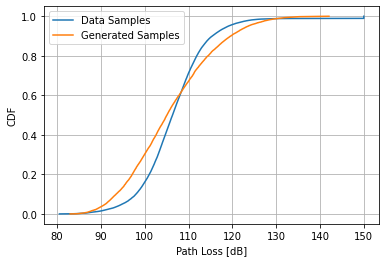

In [34]:
# Evaluate path loss
results.eval_path_loss(nPath_gen)

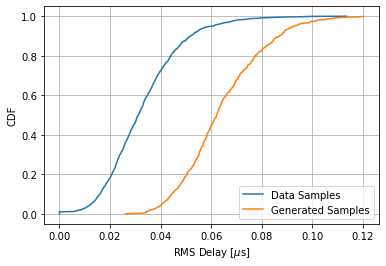

In [35]:
# Evaluate RMS delay spread
results.eval_rms_delay(nPath_gen)

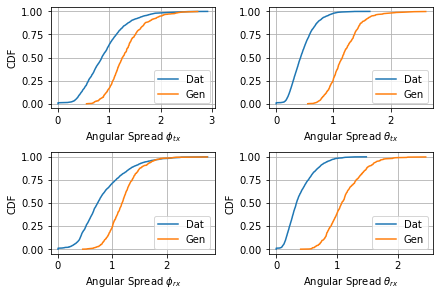

In [36]:
# Evaluate angular spread
results.eval_angular_spread(nPath_gen)

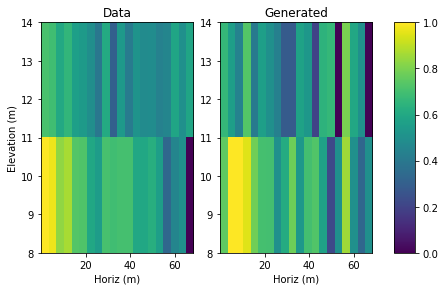

In [37]:
# Evaluate LOS probability
results.eval_plos()

In [57]:
# Prepare the generated data for path loss scatter plot against distance
nlos_pls = gen_samp[:,np.array(range(nPath_gen))*6+4]
nlos_prs_lin = np.sum(10**((0-nlos_pls)/10),axis=1)
nlos_prs = 10*np.log10(nlos_prs_lin)
nlos_pls = -nlos_prs
nlos_d = gen_samp[:,0]

array([89.12863354, 86.90123968, 86.17534579, 82.92978862, 82.63297226,
       87.80518077, 87.8586978 , 81.70730883, 87.07837575, 88.20937641])

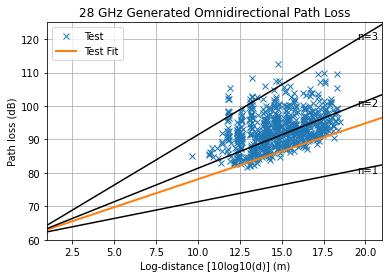

NLOS locations - PLE:1.67, SF:4.50


In [63]:
# Compute the PLE and SF for generated data
ple_nlos, sf_nlos_std = compute_ple(nlos_d,
                                  nlos_pls, fc, d0)

# Scatter plot 
plt.plot(10*np.log10(train_data['dist'][nlos_index]),train_data['pl_omni'][nlos_index],'x',c='C0')
plt.xlim([1,21])
plt.ylim([60,125])

# Plot the fit line 
plt.plot(np.linspace(0,21,num=100),fspl0+ple_nlos*np.linspace(0,21,num=100),
         c='C1',lw=2)
plt.legend(['Test','Test Fit'])

# Plot the reference lines
plt.plot(np.linspace(0,21,num=100),fspl0+2*np.linspace(0,21,num=100),'k')
plt.plot(np.linspace(0,21,num=100),fspl0+1*np.linspace(0,21,num=100),'k')
plt.plot(np.linspace(0,21,num=100),fspl0+3*np.linspace(0,21,num=100),'k')
plt.annotate('n=1',(19.5,80))
plt.annotate('n=2',(19.5,100))
plt.annotate('n=3',(19.5,120))
plt.title('28 GHz Generated Omnidirectional Path Loss')
plt.xlabel('Log-distance [10log10(d)] (m)')
plt.ylabel('Path loss (dB)')
plt.grid(True)
plt.show()

print(f'NLOS locations - PLE:{ple_nlos:.2f}, SF:{sf_nlos_std:.2f}')